<!-- Customize the font and markdown size -->
# Custom RL Algorithm with ev2gym gym environment🚗🚗🔋🔋📉
---

This Notebook provides a simple example of how to develop your own custom RL environment using the OpenAI Gym interface. We will use the **simple configuration of ev2gym** for the power *setpoint tracking problem*. We will then train a simple DQN agent to solve the environment.


- ev2gym simulates a Charge Point Operator (CPO) controlling a **fixed number of charging stations** scattered in a city where EVs that arrive and depart.

- The goal of the CPO is to **minimize the difference between the power setpoint and the actual power** consumed by the charging stations.

 - The CPO can control the current(**A**) of each port of each charging station. The current is limited by the **maximum current**(**I**) of the charging station and the **maximum current**(**I**) of the port.



In [1]:
#Install the required packages
!pip install ev2gym

In [2]:
import numpy as np
from ev2gym.models.ev2gym_env import EV2Gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import math
from collections import namedtuple, deque
from itertools import count
import matplotlib.pyplot as plt
import pandas as pd
from state import V2G_profit_max
from reward import profit_maximization  # 確保 v2g_profit_reward 定義在 reward.py 中

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

(array([0.  , 0.  , 5.17, 5.17, 5.17, 5.17, 1.07, 1.07, 1.07, 1.07, 1.47,
        1.47, 1.47, 1.47, 5.08, 5.08, 5.08, 5.08, 4.49, 4.49, 4.49, 4.49,
         nan, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]),
 {})

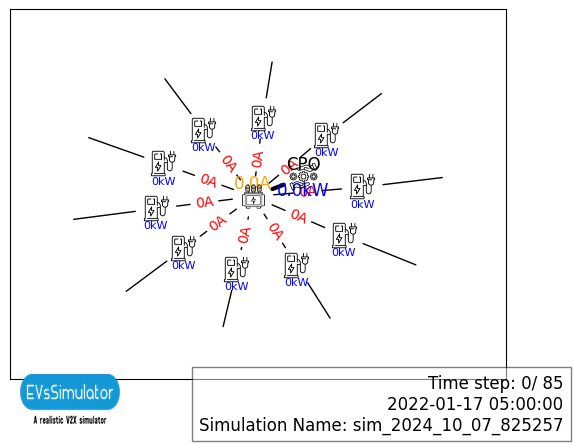

In [3]:
# 超參數
BATCH_SIZE = 64
GAMMA = 0.99
TAU = 0.005
LR = 1e-4  # 學習率

# 使用绝对路径配置文件
config_file = "C:\\Users\\River\\Desktop\\EV2Gym-main\\EV2Gym-main\\ev2gym\\example_config_files\\V2GProfitMax.yaml"

# 加載家庭負載數據
household_loads_df = pd.read_csv('C:\\Users\\River\\Desktop\\EV2Gym-main\\EV2Gym-main\\ev2gym\\data\\standardlastprofil-haushalte-2023.csv')
household_loads = household_loads_df['SLP-Bandlastkunden HB [kWh]'].values

# 讀取電價資料 (假設您只需要 'Germany/Luxembourg [€/MWh]' 列的電價)
electricity_prices_df = pd.read_csv('C:/Users/River/Desktop/EV2Gym-main/EV2Gym-main/ev2gym/data/Day-ahead_prices_202301010000_202401010000_Quarterhour.csv', sep=';', engine='python')

# 提取電價列並將其轉換為 numpy 陣列
electricity_prices = electricity_prices_df['Germany/Luxembourg [€/MWh] Calculated resolutions'].values


# 创建环境
env = EV2Gym(config_file,
             render_mode=True,
             seed=42,
             save_plots=False,
             save_replay=False)

# 將家庭負載數據傳遞給環境
env.household_loads = household_loads

# 加入電價資料到環境中
env.electricity_prices = electricity_prices

# 設定狀態函數為 V2G_profit_max
env.state_function = V2G_profit_max

# 設定新的獎勵函數為 v2g_profit_reward
env.set_reward_function(profit_maximization)

# 計算所有充電站的總埠數並設置 n_actions
total_ports = sum(cs.n_ports for cs in env.charging_stations)
n_actions = total_ports  # 確保 n_actions 與總埠數相同

# Get the initial state
env.reset()

In [4]:
# Actor network
class Actor(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(Actor, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        output = torch.tanh(self.layer3(x))  # 使用 Tanh 激活函數
        output = output.squeeze(0)  # 去掉多餘的維度
        #print(f"Actor output shape: {output.shape}")  # 打印形狀
        return output
# Critic network
class Critic(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(Critic, self).__init__()
        self.layer1 = nn.Linear(n_observations + n_actions, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, 1)

    def forward(self, state, action):
        # 如果 action 是 1D 張量，則將其擴展為 2D
        if action.dim() == 1:
            action = action.unsqueeze(1)  # 使 action 張量的形狀變為 [batch_size, 1]

        # 拼接 state 和 action
        x = torch.cat([state, action], dim=1)
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

Example reward function that penalizes the squared difference between the minimum of the power setpoint or the power potential and the actual power consumed by the charging stations.

$$
R(s_t,a_t,s_{t+1}) = - (min(P^{setpoint}, P^{potential}) - P^{actual})^2
$$

In [5]:
# 定義 Transition
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [6]:
# OUNoise 的定義
class OUNoise:
    def __init__(self, action_dim, scale=0.1, mu=0, theta=0.15, sigma=0.2):
        self.action_dim = action_dim
        self.scale = scale
        self.mu = mu
        self.theta = theta
        self.sigma = sigma
        self.state = np.ones(self.action_dim) * self.mu
        self.reset()

    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu

    def noise(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state * self.scale


In [7]:
# Initialize networks
state, _ = env.reset()
n_observations = len(state)

actor = Actor(n_observations, n_actions).to(device)
target_actor = Actor(n_observations, n_actions).to(device)
target_actor.load_state_dict(actor.state_dict())

critic = Critic(n_observations, n_actions).to(device)
target_critic = Critic(n_observations, n_actions).to(device)
target_critic.load_state_dict(critic.state_dict())

optimizer_actor = optim.Adam(actor.parameters(), lr=LR)
optimizer_critic = optim.Adam(critic.parameters(), lr=LR)
memory = ReplayMemory(10000)

# Initialize OUNoise
ou_noise = OUNoise(action_dim=n_actions)

steps_done = 0

In [8]:
# Select action with noise
# 修改 select_action 函數
def select_action(state):
    state = state.unsqueeze(0)  # 保證 state 是二維的
    action = actor(state).cpu().data.numpy()  # 直接從 Actor 網絡獲取行動
    action = action.squeeze(0)  # 去掉多餘的維度
    action += ou_noise.noise()  # 添加探索噪音
    action = np.clip(action, -1, 1)  # 確保行動在邊界內

    # 調整 action 長度使其符合 total_ports
    if len(action) != total_ports:
        action = np.resize(action, total_ports)
    
    # 根據當前步驟的電價調整行動
    current_price = env.electricity_prices[env.current_step]
    
    # 如果電價低於某個閾值，增加充電力度
    if current_price < 50:  # 假設 50 €/MWh 是低電價閾值
        action = np.clip(action * 1.2, -1, 1)  # 增強充電力度
    # 如果電價高於某個閾值，減少充電力度或增加放電
    elif current_price > 100:  # 假設 100 €/MWh 是高電價閾值
        action = np.clip(action * 0.8, -1, 1)  # 減少充電力度
    
    return action

In [9]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    # 過濾掉 None 的 next_state，並調整其他批次數據
    valid_indices = [i for i, s in enumerate(batch.next_state) if s is not None]
    state_batch = torch.cat([batch.state[i].float() for i in valid_indices])
    next_state_batch = torch.cat([batch.next_state[i].float() for i in valid_indices if batch.next_state[i] is not None])

    # 確保 action 是 Tensor 格式，並保留二維結構
    action_batch = torch.stack([torch.tensor(batch.action[i], dtype=torch.float32) if isinstance(batch.action[i], np.ndarray) else batch.action[i].float() for i in valid_indices])
    
    reward_batch = torch.cat([batch.reward[i].clone().detach() for i in valid_indices])


    # 檢查拼接後的維度
    #print(f"State batch shape: {state_batch.shape}")
    #print(f"Action batch shape: {action_batch.shape}")
    #print(f"Next state batch shape: {next_state_batch.shape}")

    # Update Critic
    with torch.no_grad():
        next_actions = target_actor(next_state_batch)
        next_state_values = target_critic(next_state_batch, next_actions).view(-1, 1)  # 確保形狀正確
        expected_state_action_values = (reward_batch.view(-1, 1) + GAMMA * next_state_values).float()  # 確保類型正確

    state_action_values = critic(state_batch, action_batch)
    critic_loss = F.mse_loss(state_action_values, expected_state_action_values)

    optimizer_critic.zero_grad()
    critic_loss.backward()
    optimizer_critic.step()

    # Update Actor
    actor_loss = -critic(state_batch, actor(state_batch)).mean()
    optimizer_actor.zero_grad()
    actor_loss.backward()
    optimizer_actor.step()
    
    #print(f'State-Action values shape: {state_action_values.shape}')
    #print(f'Expected State-Action values shape: {expected_state_action_values.shape}')

    # Soft update of target networks
    for target_param, param in zip(target_critic.parameters(), critic.parameters()):
        target_param.data.copy_(TAU * param.data + (1.0 - TAU) * target_param.data)

    for target_param, param in zip(target_actor.parameters(), actor.parameters()):
        target_param.data.copy_(TAU * param.data + (1.0 - TAU) * target_param.data)

In [10]:
episode_rewards = []
episode_stats = []

if torch.cuda.is_available():
    num_episodes = 200
else:
    num_episodes = 50

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, _ = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    
    ou_noise.reset()  # Reset noise at the beginning of each episode
    episode_reward = 0
    for t in count():
        action = select_action(state)

        # 檢查 action 的大小
        if len(action) != n_actions:
            raise ValueError(f"Expected action length {n_actions}, but got {len(action)}.")

        observation, reward, done, truncated, stats = env.step(action)
        episode_reward += reward
        reward = torch.tensor([reward], dtype=torch.float32, device=device)        

        if done:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        memory.push(state, action, next_state, reward)
        state = next_state

        optimize_model()
        
        if done or truncated:
            episode_rewards.append(episode_reward)
            episode_stats.append(stats)
            print(f'Episode {i_episode} finished after {t + 1} timesteps, total reward: {episode_reward:.2f}')
            break

Episode 0 finished after 85 timesteps, total reward: 3787.29
Episode 1 finished after 85 timesteps, total reward: 3847.14
Episode 2 finished after 85 timesteps, total reward: 3847.39
Episode 3 finished after 85 timesteps, total reward: 3839.86
Episode 4 finished after 85 timesteps, total reward: 3847.42
Episode 5 finished after 85 timesteps, total reward: 3841.44
Episode 6 finished after 85 timesteps, total reward: 3848.36
Episode 7 finished after 85 timesteps, total reward: 3837.60
Episode 8 finished after 85 timesteps, total reward: 3845.86
Episode 9 finished after 85 timesteps, total reward: 3834.62
Episode 10 finished after 85 timesteps, total reward: 3845.18
Episode 11 finished after 85 timesteps, total reward: 3847.95
Episode 12 finished after 85 timesteps, total reward: 3838.15
Episode 13 finished after 85 timesteps, total reward: 3844.57
Episode 14 finished after 85 timesteps, total reward: 3842.85
Episode 15 finished after 85 timesteps, total reward: 3846.43
Episode 16 finishe

In [16]:
# Save results
results = pd.DataFrame(episode_rewards, columns=["Episode Reward"])
results.to_csv("training_results.csv", index=False)

In [17]:
# 繪製訓練結果
plt.plot(episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Results')
plt.show()

Episode 0 finished after 50 timesteps, total reward: -1107.70
Episode 1 finished after 50 timesteps, total reward: -1722.59
Episode 2 finished after 50 timesteps, total reward: -501.52
Episode 3 finished after 50 timesteps, total reward: -1248.62
Episode 4 finished after 50 timesteps, total reward: -538.32
Episode 5 finished after 50 timesteps, total reward: -1010.05
Episode 6 finished after 50 timesteps, total reward: -4154.59
Episode 7 finished after 50 timesteps, total reward: -7813.96
Episode 8 finished after 50 timesteps, total reward: -315.98
Episode 9 finished after 50 timesteps, total reward: -6612.62
Episode 10 finished after 50 timesteps, total reward: -8803.20
Episode 11 finished after 50 timesteps, total reward: -10661.28
Episode 12 finished after 50 timesteps, total reward: -521.34
Episode 13 finished after 50 timesteps, total reward: -1370.41
Episode 14 finished after 50 timesteps, total reward: -9494.31
Episode 15 finished after 50 timesteps, total reward: -2376.75
Episo

Plot other metrics from the info dictionary returned by the environment. For example, the number of times the agent charged or discharged the EVs.